In [179]:
import pandas as pd
import numpy as np

In [180]:
df = pd.read_csv('train_oil.csv')
df.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,PETROBRAS,ONSHORE,OIL,NEARLY DEPLETED,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,61.3833,1.7500,CNR,OFFSHORE,OIL,NEARLY DEPLETED,RIFT,8988,JURASSIC,SANDSTONE,425.0,300.0,22.0,750.0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.2287,-115.8008,NUMEROUS,ONSHORE,OIL,UNKNOWN,FORELAND,9306,DEVONIAN,DOLOMITE,233.0,167.0,11.8,1407.0


In [181]:
df["Onshore/Offshore"].value_counts()

Onshore/Offshore
ONSHORE             218
OFFSHORE             86
ONSHORE-OFFSHORE      5
Name: count, dtype: int64

Либо удалить *ONSHORE-OFFSHORE*, либо пытаться их как-то интерпретировать (например, считать значения для logreg от $0.4$ до $0.6$ как *ONSHORE-OFFSHORE*)

### Вариант 1. Интерпретация через промежуточный мультикласс

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

In [183]:
df["Latitude"] = df["Latitude"].fillna(df["Latitude"].mean())
df["Longitude"] = df["Longitude"].fillna(df["Longitude"].mean())

In [184]:
from sklearn.preprocessing import MinMaxScaler

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [185]:
non_numeric_cols = df.select_dtypes(include=['object']).columns
df[non_numeric_cols].nunique()

Field name            285
Reservoir unit        258
Country                42
Region                  7
Basin name             93
Tectonic regime        55
Operator company      138
Onshore/Offshore        3
Hydrocarbon type        4
Reservoir status       13
Structural setting     43
Reservoir period       22
Lithology              13
dtype: int64

Удалим все колонки, где > 60 уникальных значений

In [186]:
df = df.drop(columns=["Field name", "Reservoir unit", "Basin name", "Operator company"])

In [187]:
from sklearn.preprocessing import MultiLabelBinarizer

class SafeMultiLabelBinarizer:
    """
    Обертка вокруг MultiLabelBinarizer с обработкой неизвестных категорий
    для старых версий scikit-learn
    """
    def __init__(self, sep='/', prefix=None):
        self.sep = sep
        self.prefix = prefix
        self.mlb = MultiLabelBinarizer()
        self.known_categories_ = set()
        
    def fit(self, series):
        """Обучает энкодер и запоминает все категории"""
        # Подготовка данных
        series_split = series.apply(
            lambda x: str(x).split(self.sep) if pd.notna(x) else []
        )
        
        # Обучаем стандартный MultiLabelBinarizer
        self.mlb.fit(series_split)
        
        # Сохраняем все известные категории
        self.known_categories_ = set(self.mlb.classes_)
        
        return self
    
    def transform(self, series):
        """Преобразует данные, игнорируя неизвестные категории"""
        def filter_unknown_categories(item):
            if pd.isna(item):
                return []
            categories = str(item).split(self.sep)
            # Фильтруем только известные категории
            return [cat for cat in categories if cat in self.known_categories_]
        
        # Применяем фильтрацию
        filtered_series = series.apply(filter_unknown_categories)
        
        # Преобразуем отфильтрованные данные
        return self.mlb.transform(filtered_series)
    
    def fit_transform(self, series):
        """Обучает и преобразует за один шаг"""
        return self.fit(series).transform(series)
    
    @property
    def classes_(self):
        return self.mlb.classes_

In [188]:
def fit_multilabel_encoders_compatible(df, columns_to_encode, sep='/', prefix=None):
    """
    Совместимая версия для старых scikit-learn
    """
    df_processed = df.copy()
    encoders = {}
    
    for column in columns_to_encode:
        if prefix is None:
            current_prefix = f'{column}_'
        else:
            current_prefix = prefix
            
        # Создаем наш безопасный энкодер
        mlb = SafeMultiLabelBinarizer(sep=sep, prefix=current_prefix)
        
        # Обучаем и преобразуем
        encoded_array = mlb.fit_transform(df_processed[column])
        
        # Создаем DataFrame с закодированными признаками
        encoded_df = pd.DataFrame(
            encoded_array,
            columns=[f'{current_prefix}{col}' for col in mlb.classes_],
            index=df_processed.index
        )
        
        # Сохраняем энкодер и обновляем данные
        encoders[column] = mlb
        df_processed = df_processed.drop(columns=[column])
        df_processed = pd.concat([df_processed, encoded_df], axis=1)
        
        print(f"Колонка '{column}' закодирована в {len(mlb.classes_)} признаков")
    
    return df_processed, encoders

def transform_with_encoders_compatible(df_new, encoders, sep='/', prefix=None):
    """
    Применяет обученные энкодеры к новым данным
    """
    df_processed = df_new.copy()
    
    for column, mlb in encoders.items():
        if prefix is None:
            current_prefix = f'{column}_'
        else:
            current_prefix = prefix
            
        # Применяем преобразование
        if column in df_processed.columns:
            encoded_array = mlb.transform(df_processed[column])

            # Создаем DataFrame с закодированными признаками
            encoded_df = pd.DataFrame(
                encoded_array,
                columns=[f'{current_prefix}{col}' for col in mlb.classes_],
                index=df_processed.index
            )
            
            # Обновляем данные
            df_processed = df_processed.drop(columns=[column])
            df_processed = pd.concat([df_processed, encoded_df], axis=1)
            
            print(f"Колонка '{column}' преобразована")
    
    return df_processed

In [189]:
df['Onshore/Offshore'] = df['Onshore/Offshore'].str.replace('-', '/')
df['Reservoir period'] = df['Reservoir period'].str.replace('-', '/')

non_numeric_cols = df.select_dtypes(include=['object']).columns
print(df[non_numeric_cols].nunique())


object_cols = df.select_dtypes(include=['object']).columns
df_encoded, encoders = fit_multilabel_encoders_compatible(df, object_cols)


Country               42
Region                 7
Tectonic regime       55
Onshore/Offshore       3
Hydrocarbon type       4
Reservoir status      13
Structural setting    43
Reservoir period      22
Lithology             13
dtype: int64
Колонка 'Country' закодирована в 42 признаков
Колонка 'Region' закодирована в 7 признаков
Колонка 'Tectonic regime' закодирована в 16 признаков
Колонка 'Onshore/Offshore' закодирована в 2 признаков
Колонка 'Hydrocarbon type' закодирована в 4 признаков
Колонка 'Reservoir status' закодирована в 13 признаков
Колонка 'Structural setting' закодирована в 13 признаков
Колонка 'Reservoir period' закодирована в 14 признаков
Колонка 'Lithology' закодирована в 13 признаков


In [190]:
df["Reservoir period"].value_counts()

Reservoir period
CRETACEOUS                78
JURASSIC                  41
NEOGENE                   39
PALEOGENE                 37
CARBONIFEROUS             29
PERMIAN                   28
DEVONIAN                  15
TRIASSIC                   8
CRETACEOUS/PALEOGENE       8
CARBONIFEROUS/PERMIAN      4
PROTEROZOIC                4
ORDOVICIAN                 3
PALEOGENE/NEOGENE          3
JURASSIC/CRETACEOUS        2
CAMBRIAN/ORDOVICIAN        2
TRIASSIC/JURASSIC          2
DEVONIAN/PERMIAN           1
CAMBRIAN                   1
DEVONIAN/CARBONIFEROUS     1
SILURIAN                   1
MESOZOIC                   1
PALEOZOIC                  1
Name: count, dtype: int64

In [191]:
df["Lithology"].value_counts()

Lithology
SANDSTONE                    184
DOLOMITE                      45
LIMESTONE                     38
SHALY SANDSTONE                6
THINLY-BEDDED SANDSTONE        6
LOW-RESISTIVITY SANDSTONE      6
CONGLOMERATE                   6
CHALK                          6
CHALKY LIMESTONE               5
DOLOMITIC LIMESTONE            3
SILTSTONE                      2
SHALE                          1
VOLCANICS                      1
Name: count, dtype: int64

In [192]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

target_columns = ['Onshore/Offshore_OFFSHORE', 'Onshore/Offshore_ONSHORE']

X = df_encoded.drop(columns=target_columns)
y = df_encoded[target_columns]

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Создаем мультилейблный классификатор
multi_label_clf = MultiOutputClassifier(
    LogisticRegression(random_state=42, max_iter=2000)
)

# Обучаем модель
multi_label_clf.fit(X_train, y_train)

# Предсказания
y_pred = multi_label_clf.predict(X_test)

In [193]:
# Функция для преобразования из мультилейбл в мультикласс
def multilabel_to_multiclass(y_multilabel):
    """
    Преобразует из формата двух колонок в один мультикласс:
    (1,0) -> 0, (0,1) -> 1, (1,1) -> 2
    """
    # Проверяем формат входных данных
    if isinstance(y_multilabel, pd.DataFrame):
        y_array = y_multilabel.values
    else:
        y_array = np.array(y_multilabel)
    
    # Преобразуем по правилам
    conditions = [
        (y_array[:, 0] == 1) & (y_array[:, 1] == 0),  # (1,0) -> 0
        (y_array[:, 0] == 0) & (y_array[:, 1] == 1),  # (0,1) -> 1
        (y_array[:, 0] == 1) & (y_array[:, 1] == 1)   # (1,1) -> 2
    ]
    
    choices = [0, 1, 2]
    y_multiclass = np.select(conditions, choices, default=-1)
    
    return y_multiclass

class_names = ['OFFSHORE', 'ONSHORE', 'ONSHORE-OFFSHORE']

# Преобразуем истинные значения и предсказания
y_test_multiclass = multilabel_to_multiclass(y_test)
y_pred_multiclass = multilabel_to_multiclass(y_pred)

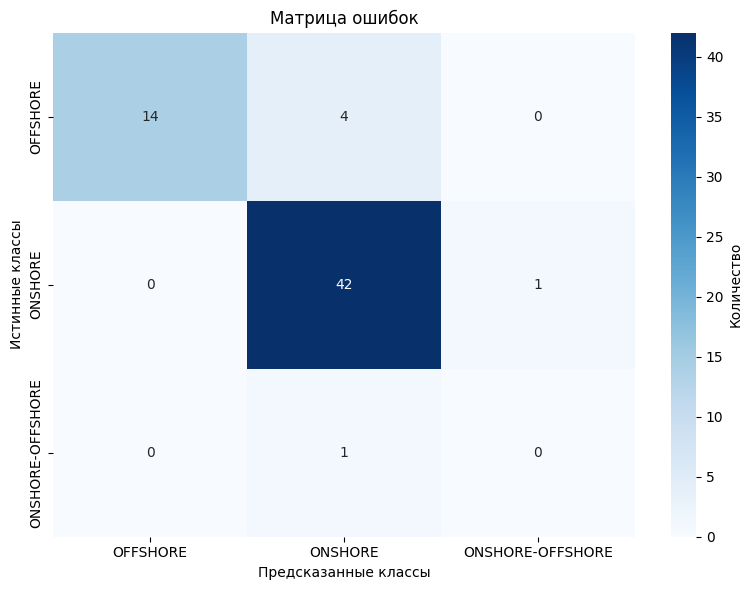

In [194]:
# Матрица ошибок

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_multiclass_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Количество'})
    plt.title('Матрица ошибок')
    plt.xlabel('Предсказанные классы')
    plt.ylabel('Истинные классы')
    plt.tight_layout()
    plt.show()
    
    return cm

# Строим матрицу ошибок
cm = plot_multiclass_confusion_matrix(y_test_multiclass, y_pred_multiclass, class_names)

In [195]:
df_test = pd.read_csv("oil_test.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      133 non-null    object 
 1   Reservoir unit                  133 non-null    object 
 2   Country                         120 non-null    object 
 3   Region                          117 non-null    object 
 4   Basin name                      125 non-null    object 
 5   Tectonic regime                 133 non-null    object 
 6   Latitude                        120 non-null    float64
 7   Longitude                       117 non-null    float64
 8   Operator company                133 non-null    object 
 9   Hydrocarbon type                133 non-null    object 
 10  Reservoir status                133 non-null    object 
 11  Structural setting              133 non-null    object 
 12  Depth                           133 

In [196]:
df_test["Latitude"] = df_test["Latitude"].fillna(df_test["Latitude"].mean())
df_test["Longitude"] = df_test["Longitude"].fillna(df_test["Longitude"].mean())

numeric_columns = df_test.select_dtypes(include=['int64', 'float64']).columns
df_test[numeric_columns] = scaler.transform(df_test[numeric_columns])

df_test = df_test.drop(columns=["Field name", "Reservoir unit", "Basin name", "Operator company"])

df_test['Reservoir period'] = df_test['Reservoir period'].str.replace('-', '/')

object_cols = df_test.select_dtypes(include=['object']).columns
df_test = transform_with_encoders_compatible(df_test, encoders)

Колонка 'Country' преобразована
Колонка 'Region' преобразована
Колонка 'Tectonic regime' преобразована
Колонка 'Hydrocarbon type' преобразована
Колонка 'Reservoir status' преобразована
Колонка 'Structural setting' преобразована
Колонка 'Reservoir period' преобразована
Колонка 'Lithology' преобразована


In [197]:
y_pred_test = multi_label_clf.predict(df_test)
y_pred_test = multilabel_to_multiclass(y_pred_test)
pd.DataFrame({'Onshore/Offshore ': y_pred_test}).to_csv('subTwoRegressions.csv', index_label='index')

In [198]:
df_encoded["Onshore/Offshore_ONSHORE"] = np.where(
    (df_encoded['Onshore/Offshore_ONSHORE'] == 1) & (df_encoded['Onshore/Offshore_OFFSHORE'] == 1),
    2,
    df_encoded['Onshore/Offshore_ONSHORE']
)

df_encoded = df_encoded.drop(columns=['Onshore/Offshore_OFFSHORE'])
target_column = ['Onshore/Offshore_ONSHORE']

X = df_encoded.drop(columns=target_column)
y = df_encoded[target_column]

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

multiclass_clf = LogisticRegression(random_state=42, max_iter=1000)
multiclass_clf.fit(X_train, y_train)

# Получаем вероятности для каждого класса
y_pred_proba = multiclass_clf.predict_proba(X_test)


y_pred_custom = np.where(
    y_pred_proba[:, 2] > 0.1,
    2,  
    np.argmax(y_pred_proba, axis=1)  
)

y_pred_custom

/home/nikita-budnikov/Proga/ML2025/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 2, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1])

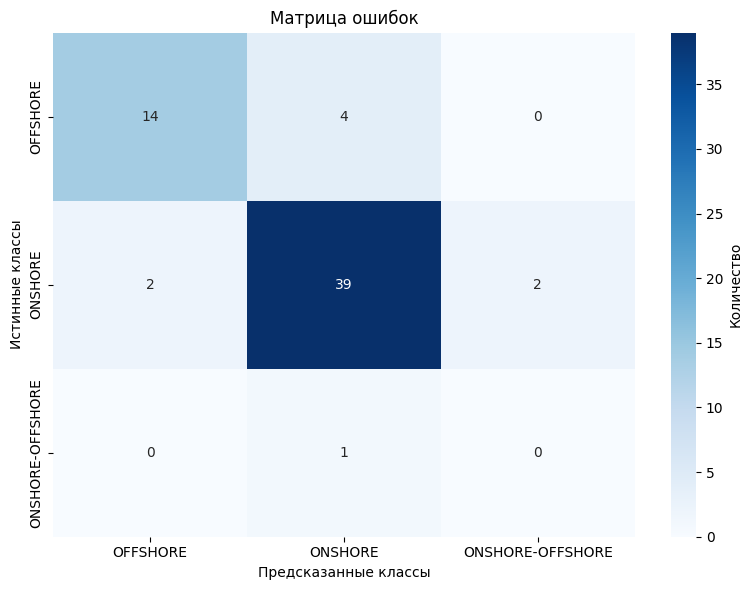

In [199]:
cm = plot_multiclass_confusion_matrix(y_test, y_pred_custom, class_names)

In [200]:
y_pred_test = multiclass_clf.predict_proba(df_test)
y_pred_test = np.where(
    y_pred_test[:, 2] > 0.1,
    2,  
    np.argmax(y_pred_test, axis=1)  
)
pd.DataFrame({'Onshore/Offshore ': y_pred_test}).to_csv('subMultiRegressions.csv', index_label='index')

### Вариант 2. Забить на *ONSHORE-OFFSHORE*

/home/nikita-budnikov/Proga/ML2025/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


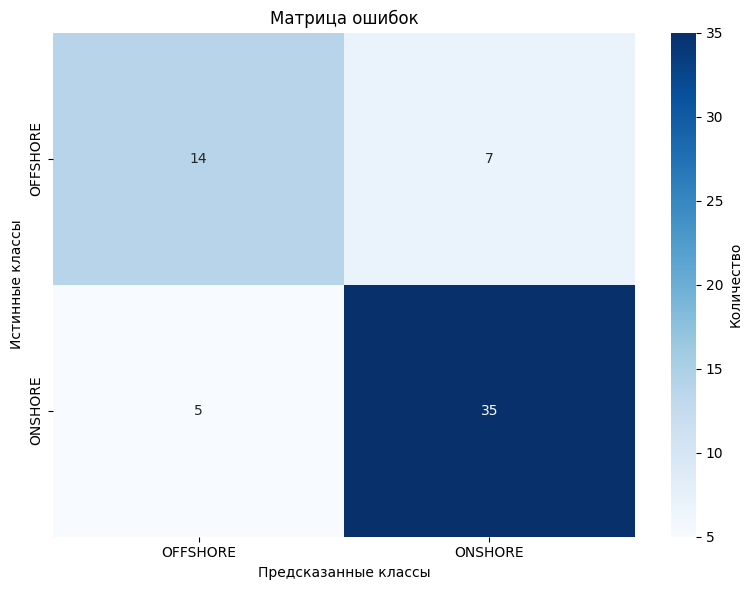

In [201]:
df_encoded = df_encoded[df_encoded['Onshore/Offshore_ONSHORE'] != 2]

target_column = ['Onshore/Offshore_ONSHORE']

X = df_encoded.drop(columns=target_column)
y = df_encoded[target_column]

# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

logReg = LogisticRegression(random_state=42, max_iter=1000)
logReg.fit(X_train, y_train)

y_pred = logReg.predict(X_test)
cm = plot_multiclass_confusion_matrix(y_test, y_pred, class_names[0:2])

In [202]:
y_pred_test = logReg.predict(df_test)
pd.DataFrame({'Onshore/Offshore ': y_pred_test}).to_csv('subRegression.csv', index_label='index')